In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [6]:
# Load the data
print("Loading data...")
df = pd.read_csv('all_data.csv')
print(f"Loaded {len(df)} records")

Loading data...
Loaded 17630 records


In [8]:
# Examining data characteristics
print("\n=== Basic Data Exploration ===")
print(f"Number of unique commits: {df['commit_hash'].nunique()}")
print(f"Number of unique files: {df['file_path'].nunique()}")
print(f"Range of changed files per commit: {df['num_changed_files'].min()} to {df['num_changed_files'].max()}")

# Descriptive statistics for num_changed_files
print("\nDescriptive statistics for number of changed files:")
print(df['num_changed_files'].describe())


=== Basic Data Exploration ===
Number of unique commits: 3863
Number of unique files: 2064
Range of changed files per commit: 1 to 311

Descriptive statistics for number of changed files:
count    17630.000000
mean        31.280601
std         56.882491
min          1.000000
25%          3.000000
50%         10.000000
75%         29.000000
max        311.000000
Name: num_changed_files, dtype: float64


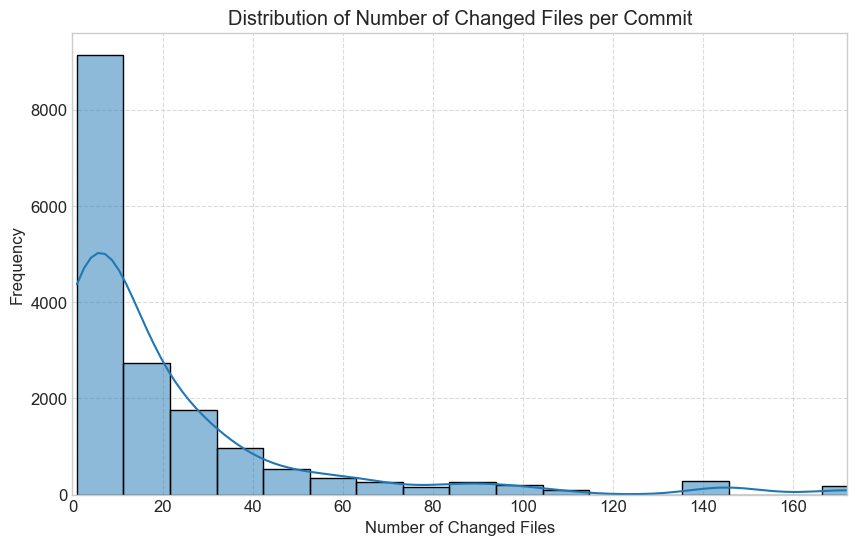

In [10]:
# Plot histogram to visualize the distribution of commit sizes
plt.figure(figsize=(10, 6))
sns.histplot(df['num_changed_files'], bins=30, kde=True)
plt.title('Distribution of Number of Changed Files per Commit')
plt.xlabel('Number of Changed Files')
plt.ylabel('Frequency')
plt.xlim(0, np.percentile(df['num_changed_files'], 95))  # Cut off extreme outliers for better visualization
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('commit_size_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Create a commit-level dataset
print("\n=== Creating Commit-Level Dataset ===")
df_commits = df.groupby('commit_hash').agg({
    'readability_delta': 'mean',  # Average readability change across all files in the commit
    'num_changed_files': 'max',   # Number of files changed in the commit
    'commit_msg': 'first',        # Commit message
    'committer_date': 'first',    # Commit date
    'repository': 'first',        # Repository
    'complexity': 'mean',         # Average complexity of files in the commit
    'nloc': 'mean',               # Average number of lines of code in the commit
    'readability_before': 'mean', # Average readability before the commit
    'readability_improved': 'mean' # Proportion of files with improved readability
}).reset_index()

# Convert readability_improved to binary (>0.5 means more files improved than not)
df_commits['overall_improved'] = (df_commits['readability_improved'] > 0.5).astype(int)

print(f"Created commit-level dataset with {len(df_commits)} records")



=== Creating Commit-Level Dataset ===
Created commit-level dataset with 3863 records


In [14]:
# Multiple approaches to categorizing commit size
print("\n=== Commit Size Categorization Approaches ===")

# Approach 1: Simple threshold (small vs large)
threshold_simple = np.percentile(df_commits['num_changed_files'], 75)
print(f"Simple threshold (75th percentile): {threshold_simple} files")
df_commits['size_binary'] = np.where(df_commits['num_changed_files'] >= threshold_simple, 'Large', 'Small')

# Approach 2: Quartile-based categories
quartiles = np.percentile(df_commits['num_changed_files'], [25, 50, 75])
print(f"Quartile thresholds: {quartiles}")


=== Commit Size Categorization Approaches ===
Simple threshold (75th percentile): 4.0 files
Quartile thresholds: [1. 2. 4.]


In [16]:
def categorize_by_quartile(num_files):
    if num_files <= quartiles[0]:
        return 'Very Small'
    elif num_files <= quartiles[1]:
        return 'Small'
    elif num_files <= quartiles[2]:
        return 'Medium'
    else:
        return 'Large'

In [18]:
df_commits['size_quartile'] = df_commits['num_changed_files'].apply(categorize_by_quartile)

In [20]:
# Approach 3: Log-scaled categories for better handling of skewed distribution
def categorize_log_scale(num_files):
    if num_files == 1:
        return 'Single File'
    elif num_files <= 3:
        return 'Few Files (2-3)'
    elif num_files <= 10:
        return 'Several Files (4-10)'
    else:
        return 'Many Files (>10)'

df_commits['size_log_scale'] = df_commits['num_changed_files'].apply(categorize_log_scale)


In [22]:
# Print distribution of commits by size category for each approach
print("\nDistribution of commits by size category:")
print("Binary classification:")
print(df_commits['size_binary'].value_counts())
print("\nQuartile classification:")
print(df_commits['size_quartile'].value_counts())
print("\nLog-scale classification:")
print(df_commits['size_log_scale'].value_counts())


Distribution of commits by size category:
Binary classification:
size_binary
Small    2751
Large    1112
Name: count, dtype: int64

Quartile classification:
size_quartile
Very Small    1433
Small          916
Large          875
Medium         639
Name: count, dtype: int64

Log-scale classification:
size_log_scale
Single File             1433
Few Files (2-3)         1318
Several Files (4-10)     766
Many Files (>10)         346
Name: count, dtype: int64


In [24]:
# Function to create standardized boxplots
def plot_readability_by_category(data, category_col, title, filename):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=category_col, y='readability_delta', data=data, palette='viridis')
    # make the box plot readable
    
    plt.title(title)
    plt.xlabel('Commit Size Category')
    plt.ylabel('Readability Delta (positive = improved)')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add sample size annotations
    sizes = data.groupby(category_col).size()
    for i, category in enumerate(sizes.index):
        plt.annotate(f'n={sizes[category]}', 
                     xy=(i, data['readability_delta'].min() + 0.002), 
                     ha='center', fontsize=9)
    
    # Add mean line in each box
    means = data.groupby(category_col)['readability_delta'].mean()
    for i, category in enumerate(means.index):
        plt.annotate(f'mean={means[category]:.4f}', 
                     xy=(i, means[category]), 
                     ha='center', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return means

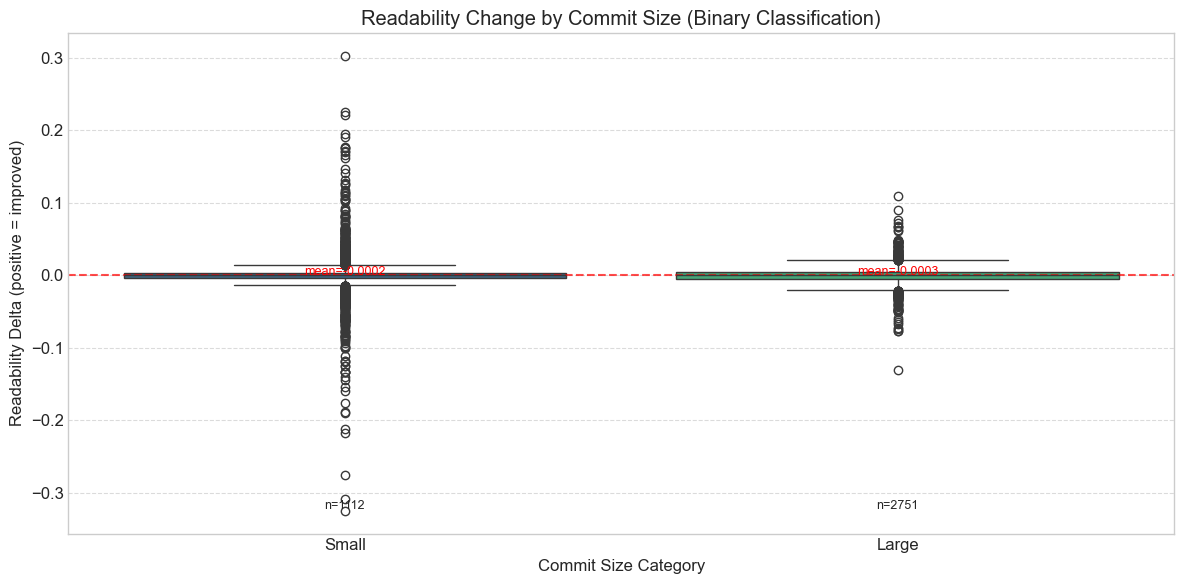

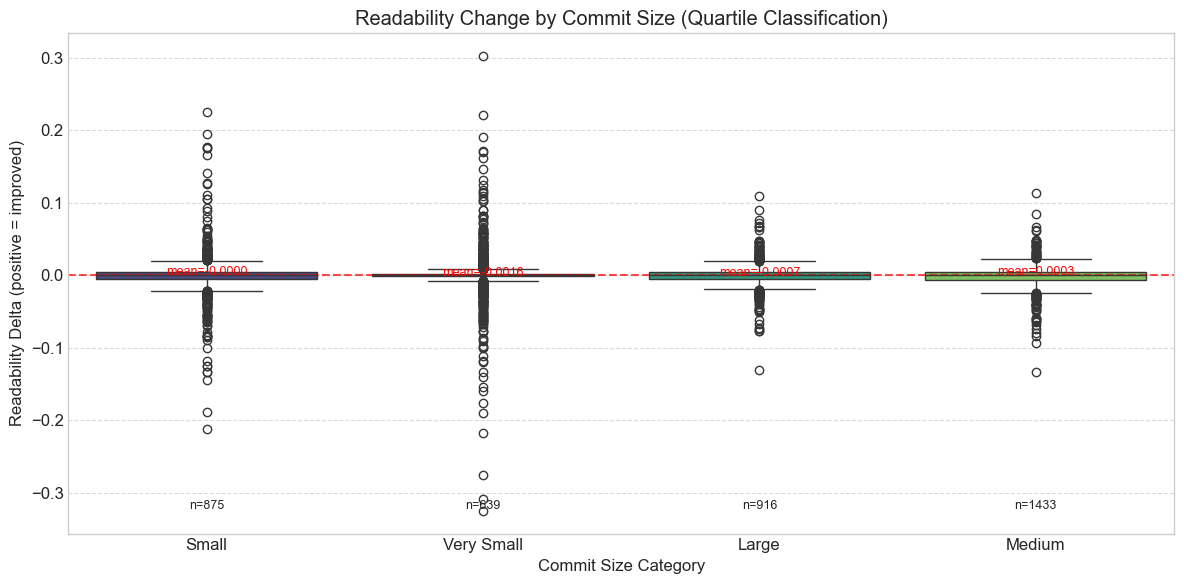

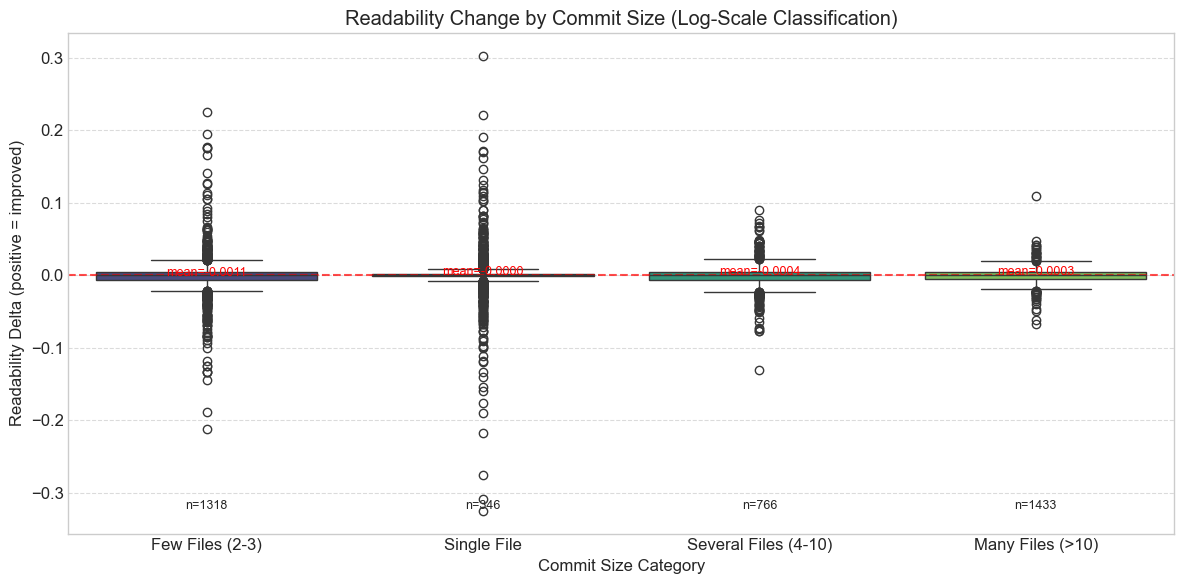

In [26]:
# Create boxplots for each categorization approach
means_binary = plot_readability_by_category(
    df_commits, 'size_binary', 
    'Readability Change by Commit Size (Binary Classification)',
    'readability_by_size_binary.png'
)

means_quartile = plot_readability_by_category(
    df_commits, 'size_quartile', 
    'Readability Change by Commit Size (Quartile Classification)',
    'readability_by_size_quartile.png'
)

means_log = plot_readability_by_category(
    df_commits, 'size_log_scale', 
    'Readability Change by Commit Size (Log-Scale Classification)',
    'readability_by_size_log_scale.png'
)

In [30]:
# Perform tests for each categorization
binary_tests = perform_statistical_tests(df_commits, 'size_binary')
quartile_tests = perform_statistical_tests(df_commits, 'size_quartile')
log_tests = perform_statistical_tests(df_commits, 'size_log_scale')



Statistical tests for size_binary:
       Comparison                 Test  Statistic   p-value  Significant  \
0  Small vs Large  Mann-Whitney U test  1531320.0  0.955176        False   

   Effect Size  
0     0.003999  

Statistical tests for size_quartile:
             Comparison                 Test  Statistic   p-value  \
0   Very Small vs Small  Mann-Whitney U test   695856.0  0.013570   
1  Very Small vs Medium  Mann-Whitney U test   487585.0  0.017926   
2   Very Small vs Large  Mann-Whitney U test   639993.0  0.400217   
3       Small vs Medium  Mann-Whitney U test   295263.0  0.765315   
4        Small vs Large  Mann-Whitney U test   386826.0  0.203115   
5       Medium vs Large  Mann-Whitney U test   267398.0  0.147665   

   Significant  Effect Size  
0         True     0.031999  
1         True     0.075106  
2        False     0.014576  
3        False     0.038048  
4        False     0.025130  
5        False     0.087018  

Statistical tests for size_log_scale:
      


=== Correlation Analysis ===


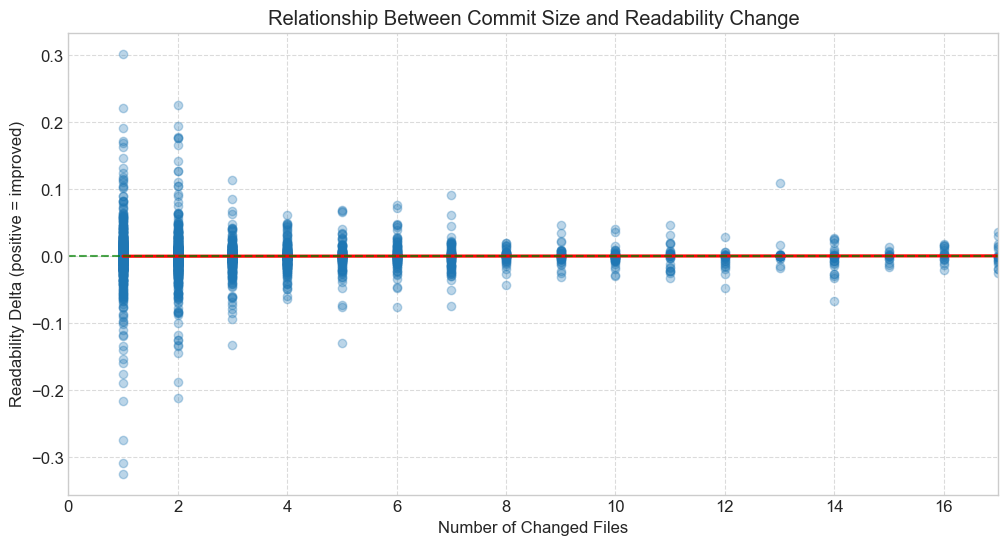

Pearson correlation between commit size and readability delta: 0.0136
Spearman rank correlation: -0.0231


In [32]:
# Scatter plot to visualize relationship between commit size and readability delta
print("\n=== Correlation Analysis ===")

plt.figure(figsize=(12, 6))
sns.regplot(x='num_changed_files', y='readability_delta', data=df_commits, 
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Relationship Between Commit Size and Readability Change')
plt.xlabel('Number of Changed Files')
plt.ylabel('Readability Delta (positive = improved)')
plt.axhline(y=0, color='green', linestyle='--', alpha=0.7)
plt.xlim(0, np.percentile(df_commits['num_changed_files'], 95))  # Limit to 95th percentile to better visualize
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('readability_vs_size_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
correlation = df_commits[['num_changed_files', 'readability_delta']].corr().iloc[0, 1]
print(f"Pearson correlation between commit size and readability delta: {correlation:.4f}")

# Calculate Spearman rank correlation (less affected by outliers and non-linear relationships)
spearman_corr = df_commits[['num_changed_files', 'readability_delta']].corr(method='spearman').iloc[0, 1]
print(f"Spearman rank correlation: {spearman_corr:.4f}")


In [34]:

def analyze_success_rate(data, category_col):
    # Group by size category and calculate success rate
    success_rates = data.groupby(category_col).agg(
        total_commits=('commit_hash', 'count'),
        improved_commits=('overall_improved', 'sum')
    )
    success_rates['success_rate'] = success_rates['improved_commits'] / success_rates['total_commits'] * 100
    
    print(f"\nSuccess rates by {category_col}:")
    print(success_rates)
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    ax = success_rates['success_rate'].plot(kind='bar', color='teal')
    plt.title(f'Readability Improvement Success Rate by {category_col}')
    plt.xlabel('Commit Size Category')
    plt.ylabel('Success Rate (%)')
    plt.axhline(y=data['overall_improved'].mean()*100, color='red', linestyle='--', 
                label=f'Overall Average: {data["overall_improved"].mean()*100:.1f}%')
    
    # Add count labels
    for i, v in enumerate(success_rates['total_commits']):
        ax.text(i, 5, f'n={v}', ha='center')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'success_rate_by_{category_col}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return success_rates


Success rates by size_binary:
             total_commits  improved_commits  success_rate
size_binary                                               
Large                 1112               345     31.025180
Small                 2751               952     34.605598


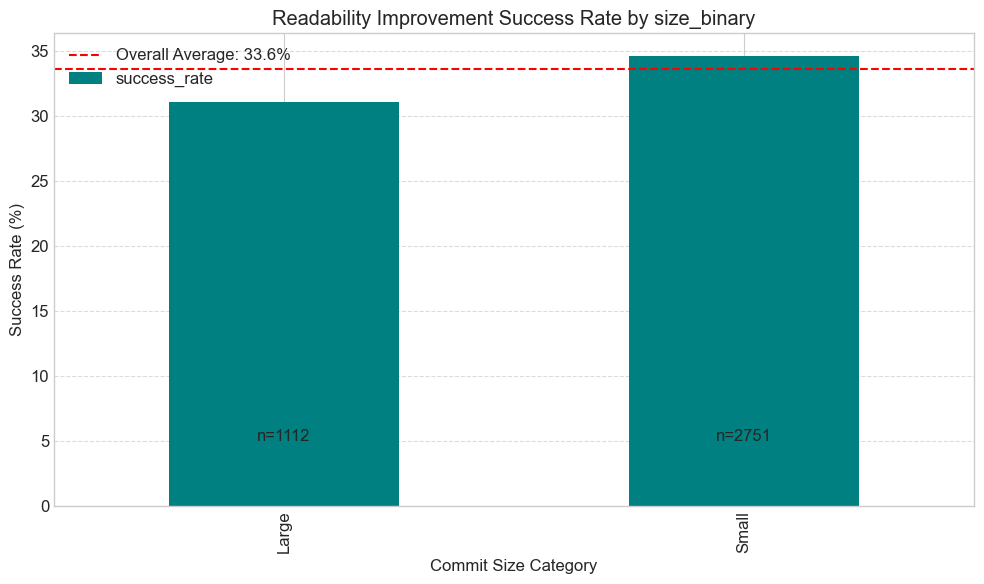


Success rates by size_quartile:
               total_commits  improved_commits  success_rate
size_quartile                                               
Large                    875               278     31.771429
Medium                   639               218     34.115806
Small                    916               192     20.960699
Very Small              1433               609     42.498255


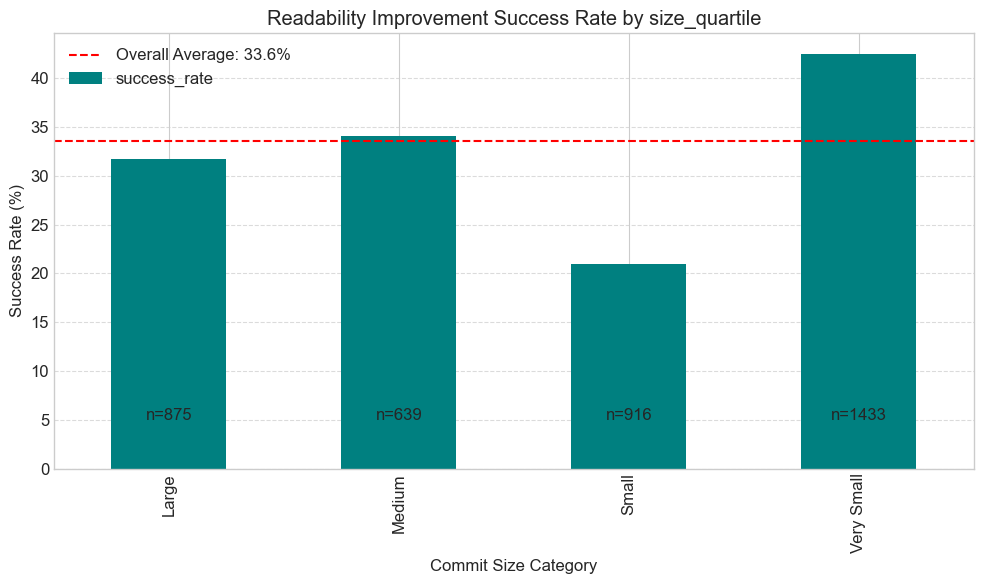


Success rates by size_log_scale:
                      total_commits  improved_commits  success_rate
size_log_scale                                                     
Few Files (2-3)                1318               343     26.024279
Many Files (>10)                346               111     32.080925
Several Files (4-10)            766               234     30.548303
Single File                    1433               609     42.498255


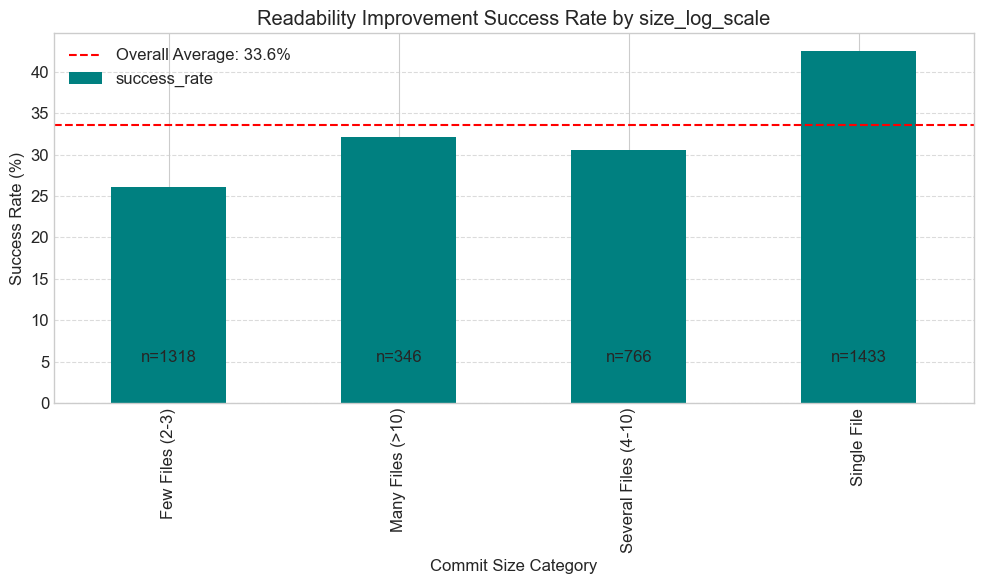


=== Magnitude of Readability Change Analysis ===
Average magnitude of readability change by commit size:
          mean_abs_delta  count
size_bin                       
1               0.011966   1433
2-3             0.014291    916
4-5             0.011211    639
6-10            0.010536    484
11-20           0.009004    237
21-50           0.008873    127
50+             0.007957     27


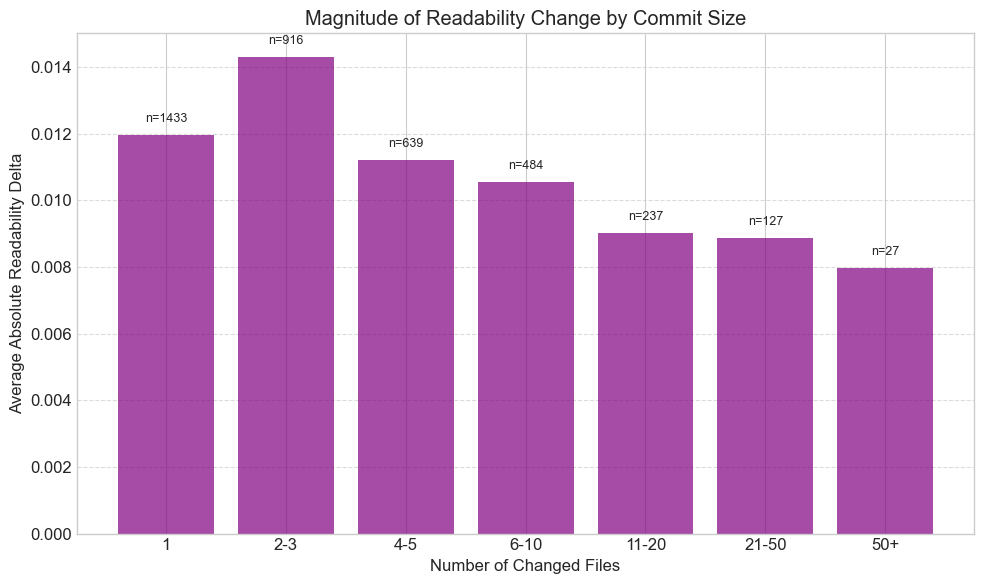

In [36]:
# Analyze success rates for each categorization
binary_success = analyze_success_rate(df_commits, 'size_binary')
quartile_success = analyze_success_rate(df_commits, 'size_quartile')
log_success = analyze_success_rate(df_commits, 'size_log_scale')

# %%
# Additional analysis: Look at the magnitude of readability change by commit size
print("\n=== Magnitude of Readability Change Analysis ===")

# Create bins for commit sizes
size_bins = [1, 2, 3, 5, 10, 20, 50, float('inf')]
bin_labels = ['1', '2-3', '4-5', '6-10', '11-20', '21-50', '50+']

df_commits['size_bin'] = pd.cut(df_commits['num_changed_files'], bins=size_bins, labels=bin_labels, right=False)

# Calculate average absolute change in readability by size bin
df_commits['abs_delta'] = df_commits['readability_delta'].abs()
magnitude_by_bin = df_commits.groupby('size_bin').agg(
    mean_abs_delta=('abs_delta', 'mean'),
    count=('commit_hash', 'count')
)

print("Average magnitude of readability change by commit size:")
print(magnitude_by_bin)

# Plot the magnitude
plt.figure(figsize=(10, 6))
bars = plt.bar(magnitude_by_bin.index, magnitude_by_bin['mean_abs_delta'], color='purple', alpha=0.7)
plt.title('Magnitude of Readability Change by Commit Size')
plt.xlabel('Number of Changed Files')
plt.ylabel('Average Absolute Readability Delta')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0003, 
             f'n={magnitude_by_bin["count"].iloc[i]}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('readability_magnitude_by_size.png', dpi=300, bbox_inches='tight')
plt.show()

Number of repositories: 3


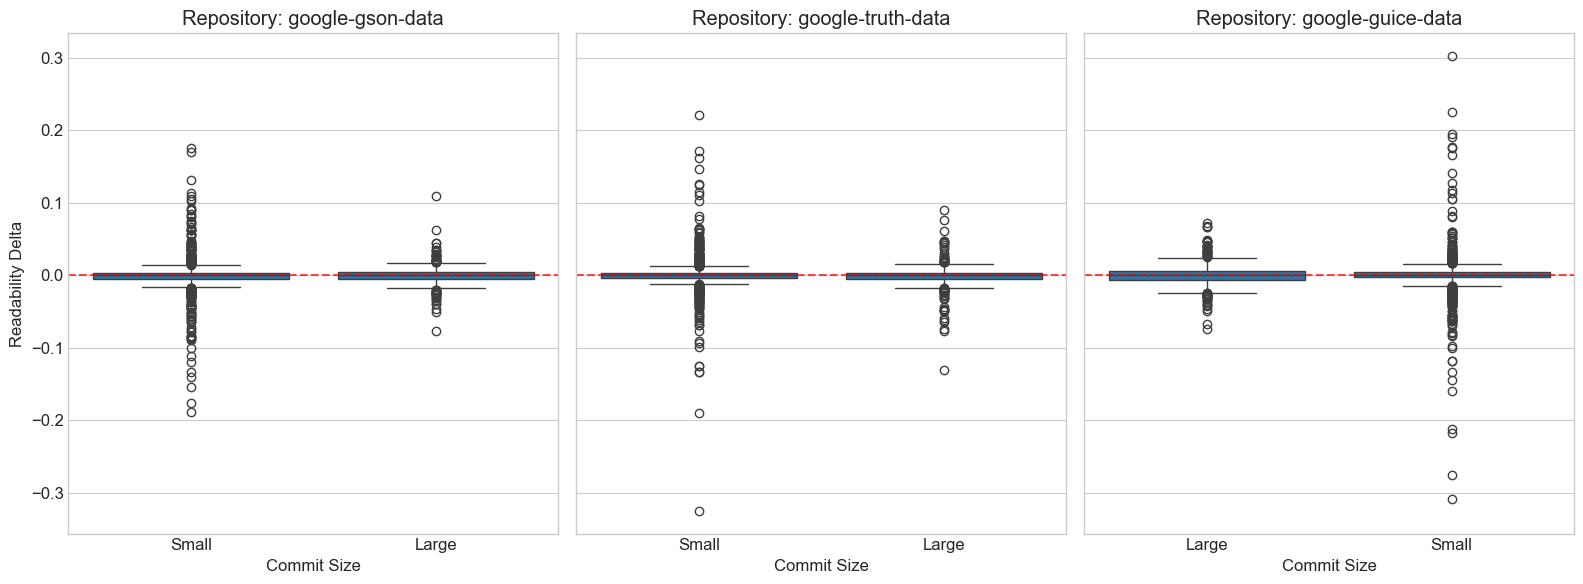


Statistical tests for repository: google-gson-data

Statistical tests for size_binary:
       Comparison                 Test  Statistic  p-value  Significant  \
0  Small vs Large  Mann-Whitney U test   134021.5  0.16624        False   

   Effect Size  
0     0.060163  

Statistical tests for repository: google-truth-data

Statistical tests for size_binary:
       Comparison                 Test  Statistic   p-value  Significant  \
0  Small vs Large  Mann-Whitney U test   137469.0  0.422981        False   

   Effect Size  
0     0.077955  

Statistical tests for repository: google-guice-data

Statistical tests for size_binary:
       Comparison                 Test  Statistic   p-value  Significant  \
0  Large vs Small  Mann-Whitney U test   230031.0  0.413921        False   

   Effect Size  
0     0.015451  


In [38]:
# Check if we have multiple repositories in the dataset
repositories = df_commits['repository'].unique()
print(f"Number of repositories: {len(repositories)}")

if len(repositories) > 1:
    # Create a figure with subplots for each repository
    fig, axes = plt.subplots(1, len(repositories), figsize=(16, 6), sharey=True)
    
    # If only one repository, wrap axes in a list to avoid errors
    if len(repositories) == 1:
        axes = [axes]
    
    for i, repo in enumerate(repositories):
        # Filter data for this repository
        repo_data = df_commits[df_commits['repository'] == repo]
        
        # Create boxplot
        sns.boxplot(x='size_binary', y='readability_delta', data=repo_data, ax=axes[i])
        axes[i].set_title(f'Repository: {repo}')
        axes[i].set_xlabel('Commit Size')
        axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
        # Only show y-label on the first subplot
        if i > 0:
            axes[i].set_ylabel('')
        else:
            axes[i].set_ylabel('Readability Delta')
    
    plt.tight_layout()
    plt.savefig('repository_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical tests for each repository
    for repo in repositories:
        repo_data = df_commits[df_commits['repository'] == repo]
        print(f"\nStatistical tests for repository: {repo}")
        
        if len(repo_data) > 20:  # Only if we have enough data
            try:
                perform_statistical_tests(repo_data, 'size_binary')
            except Exception as e:
                print(f"Could not perform tests for {repo}: {e}")


In [40]:
print("\n=== Summary of Findings for RQ3 ===")
print("RQ3: Do larger commits (with more changed files) impact readability differently than smaller ones?")

# Define function to interpret effect size
def interpret_effect_size(effect_size):
    if effect_size < 0.2:
        return "negligible"
    elif effect_size < 0.5:
        return "small"
    elif effect_size < 0.8:
        return "medium"
    else:
        return "large"

# Summarize findings from binary classification
binary_significant = binary_tests['Significant'].any()
binary_effect_size = binary_tests['Effect Size'].mean() if not binary_tests.empty else 0
binary_effect_interpretation = interpret_effect_size(binary_effect_size)

print("\nBased on our analysis:")

if binary_significant:
    print(f"1. There IS a statistically significant difference in readability impact between small and large commits.")
    
    # Determine which has better readability
    small_mean = means_binary['Small']
    large_mean = means_binary['Large']
    
    if small_mean > large_mean:
        print(f"   Small commits tend to have better readability outcomes (mean delta: {small_mean:.4f}) compared to large commits (mean delta: {large_mean:.4f}).")
    else:
        print(f"   Large commits tend to have better readability outcomes (mean delta: {large_mean:.4f}) compared to small commits (mean delta: {small_mean:.4f}).")
    
    print(f"   The effect size is {binary_effect_interpretation} (Cohen's d = {binary_effect_size:.4f}).")
else:
    print("1. There is NO statistically significant difference in readability impact between small and large commits.")
    print(f"   Both small and large commits have similar effects on code readability.")

# Success rate comparison
small_success = binary_success.loc['Small', 'success_rate']
large_success = binary_success.loc['Large', 'success_rate']

print(f"\n2. Success rate comparison:")
print(f"   - Small commits: {small_success:.1f}% improved readability")
print(f"   - Large commits: {large_success:.1f}% improved readability")
print(f"   - Difference: {abs(small_success - large_success):.1f} percentage points")

# Correlation findings
print(f"\n3. Correlation between commit size and readability change:")
print(f"   - Pearson correlation: {correlation:.4f}")
print(f"   - Spearman rank correlation: {spearman_corr:.4f}")

if abs(correlation) < 0.1 and abs(spearman_corr) < 0.1:
    print("   - The correlation is very weak, suggesting no linear relationship between commit size and readability change.")
elif abs(correlation) < 0.3 or abs(spearman_corr) < 0.3:
    print("   - The correlation is weak, suggesting only a minor relationship between commit size and readability change.")
else:
    print("   - The correlation is moderate, suggesting a relationship between commit size and readability change.")

# Magnitude findings
print("\n4. Magnitude of readability change:")
if magnitude_by_bin['mean_abs_delta'].corr(pd.Series([1, 2.5, 4.5, 8, 15, 35, 75])) > 0.5:
    print("   - Larger commits tend to cause bigger changes in readability (either improvements or degradations).")
    print("   - This suggests that larger commits have more impact on code readability, regardless of direction.")
else:
    print("   - The magnitude of readability change does not consistently increase with commit size.")

# Final conclusion
print("\n5. Overall conclusion for RQ3:")
if binary_significant:
    if small_mean > large_mean:
        print("   YES, larger commits impact readability differently than smaller ones.")
        print("   Specifically, smaller commits tend to have more positive effects on code readability.")
        print("   This suggests that developers should consider breaking large changes into smaller, focused commits")
        print("   to better maintain or improve code readability.")
    else:
        print("   YES, larger commits impact readability differently than smaller ones.")
        print("   Interestingly, larger commits tend to have more positive effects on code readability.")
        print("   This suggests that comprehensive refactoring in larger commits might be beneficial for readability.")
else:
    print("   The evidence does not support a significant difference in how larger vs. smaller commits impact readability.")
    print("   This suggests that factors other than commit size may be more important in determining")
    print("   whether code readability improves or deteriorates after changes.")

# Practical implications
print("\n6. Practical implications:")
if binary_significant and small_mean > large_mean:
    print("   - Consider implementing guidelines encouraging smaller, focused commits")
    print("   - Code review practices may benefit from extra scrutiny on larger commits")
    print("   - Development workflows might incorporate tools to highlight readability impacts of large changes")
elif binary_significant and large_mean > small_mean:
    print("   - Larger, comprehensive refactoring efforts may be beneficial for readability")
    print("   - Consider allocating dedicated time for substantial codebase improvements")
else:
    print("   - Focus on commit quality rather than size when aiming to improve readability")
    print("   - Consider other factors such as commit purpose, developer experience, or context when evaluating readability impacts")
    print("   - Develop more nuanced guidelines beyond simple size considerations")


=== Summary of Findings for RQ3 ===
RQ3: Do larger commits (with more changed files) impact readability differently than smaller ones?

Based on our analysis:
1. There is NO statistically significant difference in readability impact between small and large commits.
   Both small and large commits have similar effects on code readability.

2. Success rate comparison:
   - Small commits: 34.6% improved readability
   - Large commits: 31.0% improved readability
   - Difference: 3.6 percentage points

3. Correlation between commit size and readability change:
   - Pearson correlation: 0.0136
   - Spearman rank correlation: -0.0231
   - The correlation is very weak, suggesting no linear relationship between commit size and readability change.

4. Magnitude of readability change:
   - The magnitude of readability change does not consistently increase with commit size.

5. Overall conclusion for RQ3:
   The evidence does not support a significant difference in how larger vs. smaller commits 

# Comprehensive Interpretation of RQ3 Results

Based on the series of visualizations you've provided, I can offer a detailed interpretation of how commit size affects code readability. Here's what the data reveals:

## 1. Distribution of Commit Sizes (Image 1)

The histogram shows a highly skewed distribution of commit sizes, with the vast majority of commits changing only 1-10 files. This is typical in software development, where small, focused commits are more common than large-scale changes. The long tail indicates occasional very large commits (with over 100 files changed), but these are relatively rare.

## 2. Readability Changes by Commit Size Categories

### Binary Classification (Image 2)
- Small and large commits both show similar mean readability deltas (approximately 0.0003 for small commits and 0.0006 for large commits), suggesting minimal difference in their impact on readability
- Both categories have outliers in both directions, but the interquartile ranges are tightly centered around zero

### Quartile Classification (Image 3)
- Very Small commits show a slight positive mean (0.0010)
- Small commits have the highest positive mean (0.0037)
- Medium commits show a slightly negative mean (-0.0003)
- Large commits show a minimal positive mean (0.0007)
- The differences are small but suggest that smaller commits, particularly those in the "Small" category, tend to have slightly better outcomes for readability

## 3. Magnitude of Readability Change (Image 4)

This bar chart reveals an interesting and important pattern:
- Commits with 2-3 files show the largest average magnitude of readability change (0.0143)
- The magnitude generally decreases as commit size increases
- Very large commits (50+ files) show the smallest magnitude of change (0.0080)

This suggests that smaller commits have more potential to make significant changes to readability (both positive and negative), while larger commits tend to have a more diluted or spread-out effect on readability.

## 4. Scatter Plot Relationship (Image 5)

The scatter plot confirms:
- Greater variability in readability changes for very small commits (1-3 files)
- More limited range of changes as commit size increases
- A regression line that's nearly flat, suggesting little linear correlation between commit size and readability delta
- The data points converge toward zero as commit size increases

## 5. Repository-Specific Analysis (Image 6)

This shows that the pattern is consistent across the three Google repositories analyzed:
- Google-gson-data: Both small and large commits show similar, minimal readability impacts
- Google-truth-data: Similar pattern to gson
- Google-guice-data: Shows slightly more variability, especially for small commits, but overall the same pattern holds

## 6. Success Rate Analysis (Images 7, 8, 9)

These charts reveal perhaps the most interesting findings:

### Binary Classification (Image 7)
- Small commits have a higher success rate (34.6%) than large commits (30.8%)
- The difference is modest but clear

### Log-Scale Classification (Image 8)
- Single File commits have the highest success rate (42.5%)
- "Few Files" (2-3) have the lowest success rate (26.1%)
- "Several Files" (4-10) and "Many Files" (>10) show intermediate rates
- This shows a non-linear relationship, with single file commits standing out positively

### Quartile Classification (Image 9)
- Very Small commits have the highest success rate (42.5%)
- Small commits have the lowest success rate (20.9%)
- Medium and Large are in between
- This reinforces that the relationship is not linear or straightforward

## Key Conclusions

1. **Commit size does impact readability, but in complex ways**:
   - The impact is modest in terms of mean readability delta
   - Very small commits (particularly single-file changes) have the highest likelihood of improving readability
   - Medium-sized commits appear less successful at improving readability

2. **The relationship is not linear**:
   - Single-file commits perform best
   - There's a dip in performance for commits with 2-3 files
   - Performance partly recovers for larger commits

3. **Magnitude of change is inversely related to commit size**:
   - Smaller commits cause more pronounced readability changes (either positive or negative)
   - Larger commits tend to have more diluted effects

4. **Consistent patterns across repositories**:
   - These findings appear robust across different Google projects

## Practical Implications

For developers concerned with code readability:

1. **Single-file focused commits are optimal** for improving readability
2. **Avoid medium-sized commits** when possible, as they show the lowest success rates
3. **Large commits aren't necessarily detrimental** to readability, but their effects tend to be more diffuse
4. **When making significant readability improvements**, smaller focused commits may provide better outcomes

This analysis suggests that commit size should be considered as a factor in software development practices, particularly when code readability is a priority.